# T0 and T2 Units Integration Example

In this notebook we will exemplify how we can integrate T0 and T2 units by having the latter process the output of the former. We will run this units in standalone mode (i.e. without the need to run the whole AMPEL system and its services).

## T0 Unit

First, as in the `t0_unit_example` notebook, we will proceed to implement our T0 unit's class by inheriting from the `AbsAlertFilter` class:

In [1]:
from ampel.base.abstract.AbsAlertFilter import AbsAlertFilter

class MinPhotopointsFilter(AbsAlertFilter):
    version=1.0
    def __init__(self, on_match_t2_units=["SNCOSMO"], base_config=None, run_config=None, logger=None):
        self.on_match_t2_units = on_match_t2_units
        
    def apply(self, ampel_alert):
        if len(ampel_alert.pps) < 65:
            return None
        return self.on_match_t2_units

Here we just implemented a simple T0 unit that filters out all alerts with less than 65 photopoints. 

Next we need a dataset over which to run the T0 unit. We will use the small dataset that's present in the same folder than this present notebook in the `Ampel-contrib-sample` repository.

In [2]:
small_test_tar_path = 'ztf_public_test.tar.gz'

Now we can instantiate our implemented T0 unit's class and give it as a parameter to the `DevAlertProcessor` in order to be run in standalone mode:

In [3]:
from ampel.ztf.pipeline.t0.DevAlertProcessor import DevAlertProcessor

my_filter = MinPhotopointsFilter()
dap = DevAlertProcessor(my_filter, use_dev_alerts=True)

We may now proceed to run our T0 unit over the dataset and measure the time it takes to be completely processed:

In [4]:
import time

print ("processing alerts from %s" % small_test_tar_path)
start = time.time()
nproc = dap.process_tar(small_test_tar_path)
end = time.time()
print ("processed %d alerts in %.2e sec"%(nproc, end-start))

processing alerts from ztf_public_test.tar.gz
2019-03-04 16:41:52 INFO - Rejecting 581355856115015008 (objectId: ZTF18abakkrv)
2019-03-04 16:41:52 INFO - Rejecting 581355856115010010 (objectId: ZTF17aabunct)
2019-03-04 16:41:52 INFO - Rejecting 581355856015015005 (objectId: ZTF18aazgcob)
2019-03-04 16:41:52 INFO - Rejecting 581355855615015001 (objectId: ZTF18abdegxq)
2019-03-04 16:41:52 INFO + Ingesting 581355851315015013 (objectId: ZTF18abakkve)
2019-03-04 16:41:52 INFO - Rejecting 581355856215015002 (objectId: ZTF18abaegzj)
2019-03-04 16:41:52 INFO + Ingesting 581355856215015007 (objectId: ZTF18abaegzi)
2019-03-04 16:41:52 INFO - Rejecting 581355856215015000 (objectId: ZTF18abaegzk)
2019-03-04 16:41:52 INFO - Rejecting 581355856215015012 (objectId: ZTF17aaaeebx)
2019-03-04 16:41:52 INFO - Rejecting 581355855015015011 (objectId: ZTF18abdfrmf)
2019-03-04 16:41:52 INFO - Rejecting 581355855015010005 (objectId: ZTF17aabuvxf)
2019-03-04 16:41:52 INFO + Ingesting 581355854915015006 (object

2019-03-04 16:41:52 INFO - Rejecting 581378392915010001 (objectId: ZTF17aabuwfr)
2019-03-04 16:41:52 INFO - Rejecting 581378392915015088 (objectId: ZTF18abadlhh)
2019-03-04 16:41:52 INFO + Ingesting 581378392815010004 (objectId: ZTF17aabvevw)
2019-03-04 16:41:52 INFO + Ingesting 581419291415015062 (objectId: ZTF18aazgcnk)
2019-03-04 16:41:52 INFO - Rejecting 581469205715010008 (objectId: ZTF18abdiegf)
2019-03-04 16:41:52 INFO - Rejecting 581469206115010015 (objectId: ZTF18abchtts)
2019-03-04 16:41:52 INFO - Rejecting 581487896115015005 (objectId: ZTF18abehfrq)
2019-03-04 16:41:52 INFO 108 alert(s) processed (time required: 0s)
processed 108 alerts in 5.99e-01 sec


Next, let's see how many alerts from the dataset passed the filter:

In [5]:
n_good, n_bad = len(dap.get_accepted_alerts()), len(dap.get_rejected_alerts())
print ("%d alerts accepted by the filter (%.2f perc)"%(n_good, 100*n_good/nproc))
print ("%d alerts rejected by the filter (%.2f perc)"%(n_bad, 100*n_bad/nproc))

40 alerts accepted by the filter (37.04 perc)
68 alerts rejected by the filter (62.96 perc)


We can also plot any of the accepted alerts in order to make sure it contains the desired amount of photopoints.

2019-03-04 16:41:53 INFO Initialized AmpelAlertPlotter in interactive mode.


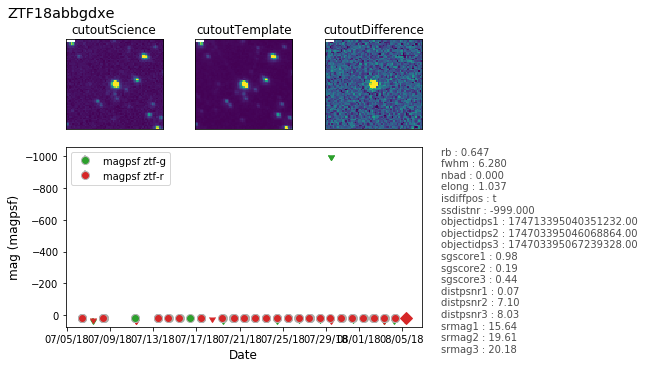

In [6]:
from ampel.ztf.view.AmpelAlertPlotter import AmpelAlertPlotter
%matplotlib inline
from random import choice

accepted = dap.get_accepted_alerts()
accepted_plot = AmpelAlertPlotter(interactive=True)
accepted_plot.summary_plot(choice(accepted))

## T2 Unit

Now, we proceed to implement a T2 unit to run over the set of alerts accepted by our previously implemented T0 unit.

In [7]:
from ampel.base.abstract.AbsT2Unit import AbsT2Unit
import numpy as np

class T2DetectRising(AbsT2Unit):
    
    def __init__(self, logger=None, base_config=None):
        pass
    
    def run(self, light_curve=None, run_config=None):
        obs_date = light_curve.get_values("obs_date")
        mag = light_curve.get_values("mag")
        mag_arg_min = np.argmin(mag)
        mag_length = len(mag)
        rising = mag_arg_min == mag_length-1
        poly = np.polyfit(obs_date, mag, 3)
        
        return {
            'rising': rising,
            'poly_coef': poly,
        }

This unit we have just implemented simply verifies if the last photopoint of the light curve is the brightest, and then returns a dictionary with a boolean value called `rising` which indicates if the brightness of the lightcurve is rising or not. As an addition, it is also returning a `poly_coef` value which contains an array with the coeficients of the fitted polynomial.

Now, we choose a random element from the set of alerts selected by our previously implemented T0 unit, and transform it into a light curve object with the help of the `_create_lc` method:

In [8]:
from ampel.ztf.utils.ZIAlertUtils import ZIAlertUtils

alert = choice(accepted)
light_curve = ZIAlertUtils._create_lc(alert.pps, alert.uls)

Afterwards, we instantiate our T2 unit and run it over the `LightCurve` object. As a result we obtain a dictionary with the relevant values our unit is calculating.

In [9]:
myt2 = T2DetectRising()
out = myt2.run(light_curve)
print(out)

{'rising': False, 'poly_coef': array([ 3.52375701e-11, -8.66251137e-05, -2.12952454e+02,  5.23504633e+08])}


/home/nmiranda/miniconda3/envs/ampel-dev-git/lib/python3.6/site-packages/ipykernel_launcher.py:15: RankWarning: Polyfit may be poorly conditioned
  from ipykernel import kernelapp as app


We can now plot the light curve in order to verify if it is indeed rising or not, as indicated by the `rising` value returned by our T2 unit:

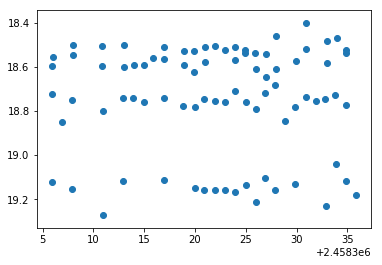

In [10]:
import matplotlib.pyplot as plt

ax = plt.axes()
ax.invert_yaxis()
ax.scatter(*zip(*light_curve.get_tuples('obs_date', 'mag')))